In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

import featuretools as ft

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats, help_model

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

# Bureau Balance dataset
Dataset has information on monthly balances of previous credits in Credit Bureau. Dataset is made of > 27 mill. observations and 3 features. No empty values or duplicates.

In [15]:
bureau_balance = help_tool.csv_download(r'Archive\home-credit-default-risk\bureau_balance.csv')
help_tool.first_look(bureau_balance)

Dataset has 27299925 observations and 3 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_BUREAU,int64,0,0.0
MONTHS_BALANCE,int64,0,0.0
STATUS,object,0,0.0


Dataset is big, sample of 100k would show the main distributions for EDA.

In [16]:
bureau_balance_sample = bureau_balance.sample(n=100000, random_state=42)

## EDA
### Categorical Feature
The values in the STATUS column can be interpreted as follows:

* 0: No DPD (Days past due)
* 1: DPD 1-30 days
* 2: DPD 31-60 days
* 3: DPD 61-90 days
* 4: DPD 91-120 days
* 5: DPD 121+ days
* C: Closed
* X: No loan for the month

Statis will be imputed on Days Past Due basis.

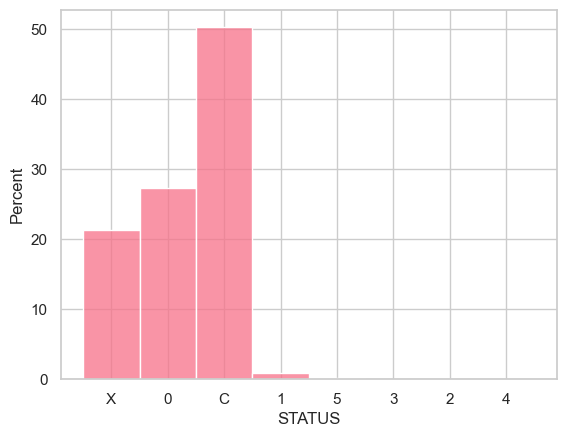

In [5]:
sns.histplot(data=bureau_balance_sample, x='STATUS', stat='percent')
plt.show()

In [17]:
bureau_balance['STATUS'] = bureau_balance['STATUS'].replace({'C': 0, 'X': np.nan}).astype(float)

### Numerical Feature
Month balance range -96 months (time only relative to the application) to day of application.

MONTHS_BALANCE


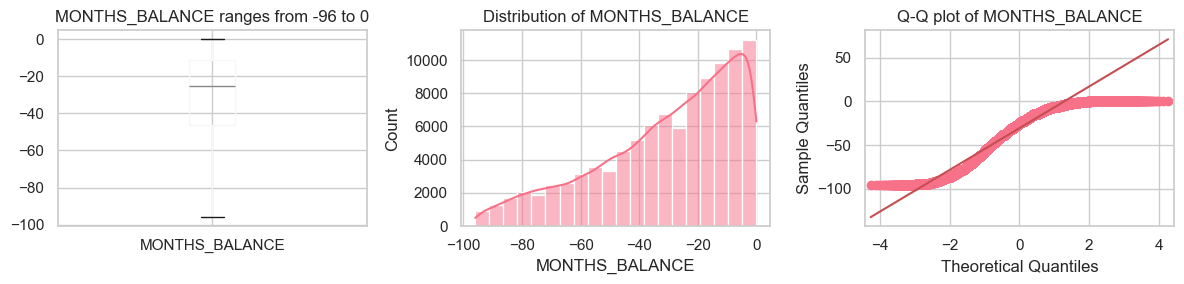

In [7]:
help_visuals.distribution_check(bureau_balance_sample[['MONTHS_BALANCE']])

Status can change over time, but not dramatically.

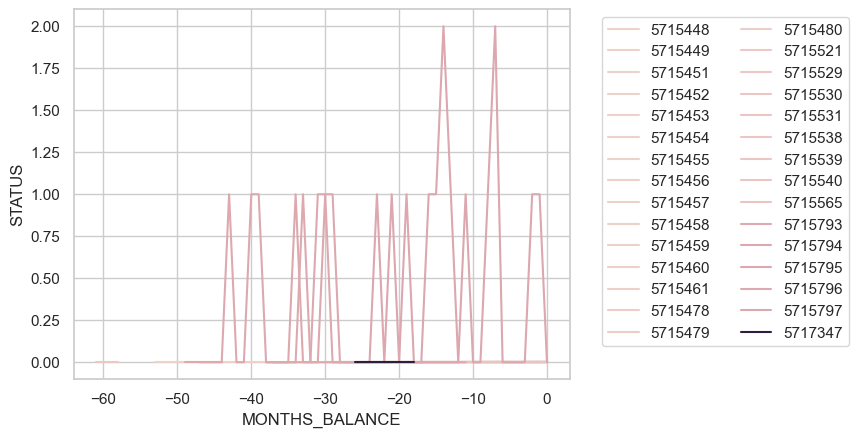

In [8]:
first_100_ids = bureau_balance['SK_ID_BUREAU'].drop_duplicates().head(30)
filtered_bureau_balance = bureau_balance[bureau_balance['SK_ID_BUREAU'].isin(first_100_ids)]

sns.lineplot(data=filtered_bureau_balance, x='MONTHS_BALANCE', y='STATUS', hue='SK_ID_BUREAU', legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

plt.show()

## Feature Aggregation

In [21]:
bureau_balance_feature_matrix = help_model.aggregated_features(bureau_balance.drop(columns=['MONTHS_BALANCE']), 'SK_ID_BUREAU')
bureau_balance_feature_matrix.shape

(817395, 4)

# Bureau dataset
Dataset has information on all client's previous credits provided by other financial institutions that were reported to Credit Bureau. Dataset is made of 1.7 mill. observations and 17 features. Some features have empty values, but no duplicates.

In [22]:
bureau = help_tool.csv_download(r'Archive\home-credit-default-risk\bureau.csv')
help_tool.first_look(bureau)

Dataset has 1716428 observations and 17 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_CURR,int64,0,0.0
SK_ID_BUREAU,int64,0,0.0
CREDIT_ACTIVE,object,0,0.0
CREDIT_CURRENCY,object,0,0.0
DAYS_CREDIT,int64,0,0.0
CREDIT_DAY_OVERDUE,int64,0,0.0
DAYS_CREDIT_ENDDATE,float64,105553,6.1
DAYS_ENDDATE_FACT,float64,633653,36.9
AMT_CREDIT_MAX_OVERDUE,float64,1124488,65.5
CNT_CREDIT_PROLONG,int64,0,0.0


## EDA
### Categorical Features
* Most cases are Closed or Active. Credit activity will be imputed to preferable vs not preferable on numerical.
* CREDIT_TYPE will be grouped to 3 categories, as Consumer Credit and Credit Card make up more than 96 % together. (note that countplot below is showing dispersed percentages).
* Absolute majority of currency is '1'.


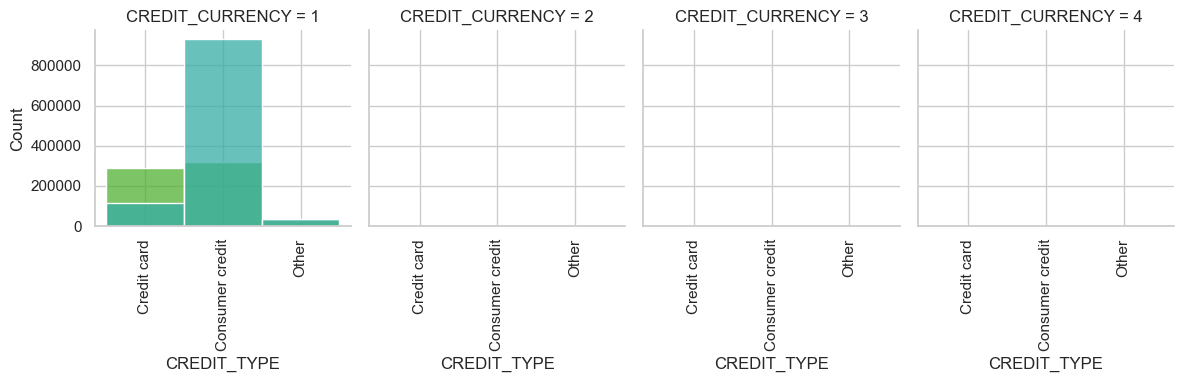

In [27]:
g = sns.FacetGrid(bureau, col="CREDIT_CURRENCY", hue="CREDIT_ACTIVE")
g.map_dataframe(sns.histplot, x="CREDIT_TYPE")


g.set_xticklabels(rotation=90)
plt.tight_layout()
plt.show()

In [23]:
def bureau_clean(df):
    # Strip 'currency ' from CREDIT_CURRENCY and convert to int
    df['CREDIT_CURRENCY'] = df['CREDIT_CURRENCY'].str.lstrip('currency ').astype(int)
    
    # Replace non-preferred CREDIT_TYPE values with 'Other'
    df['CREDIT_TYPE'] = df['CREDIT_TYPE'].where(df['CREDIT_TYPE'].isin(['Credit card', 'Consumer credit']), 'Other')

    # Map CREDIT_ACTIVE values to numerical scale
    credit_active_map = {'Closed': 2, 'Active': 1, 'Sold': -1, 'Bad debt': -2}
    df['CREDIT_ACTIVE'] = df['CREDIT_ACTIVE'].replace(credit_active_map).astype(int)

bureau_clean(bureau)


### Numerical Features

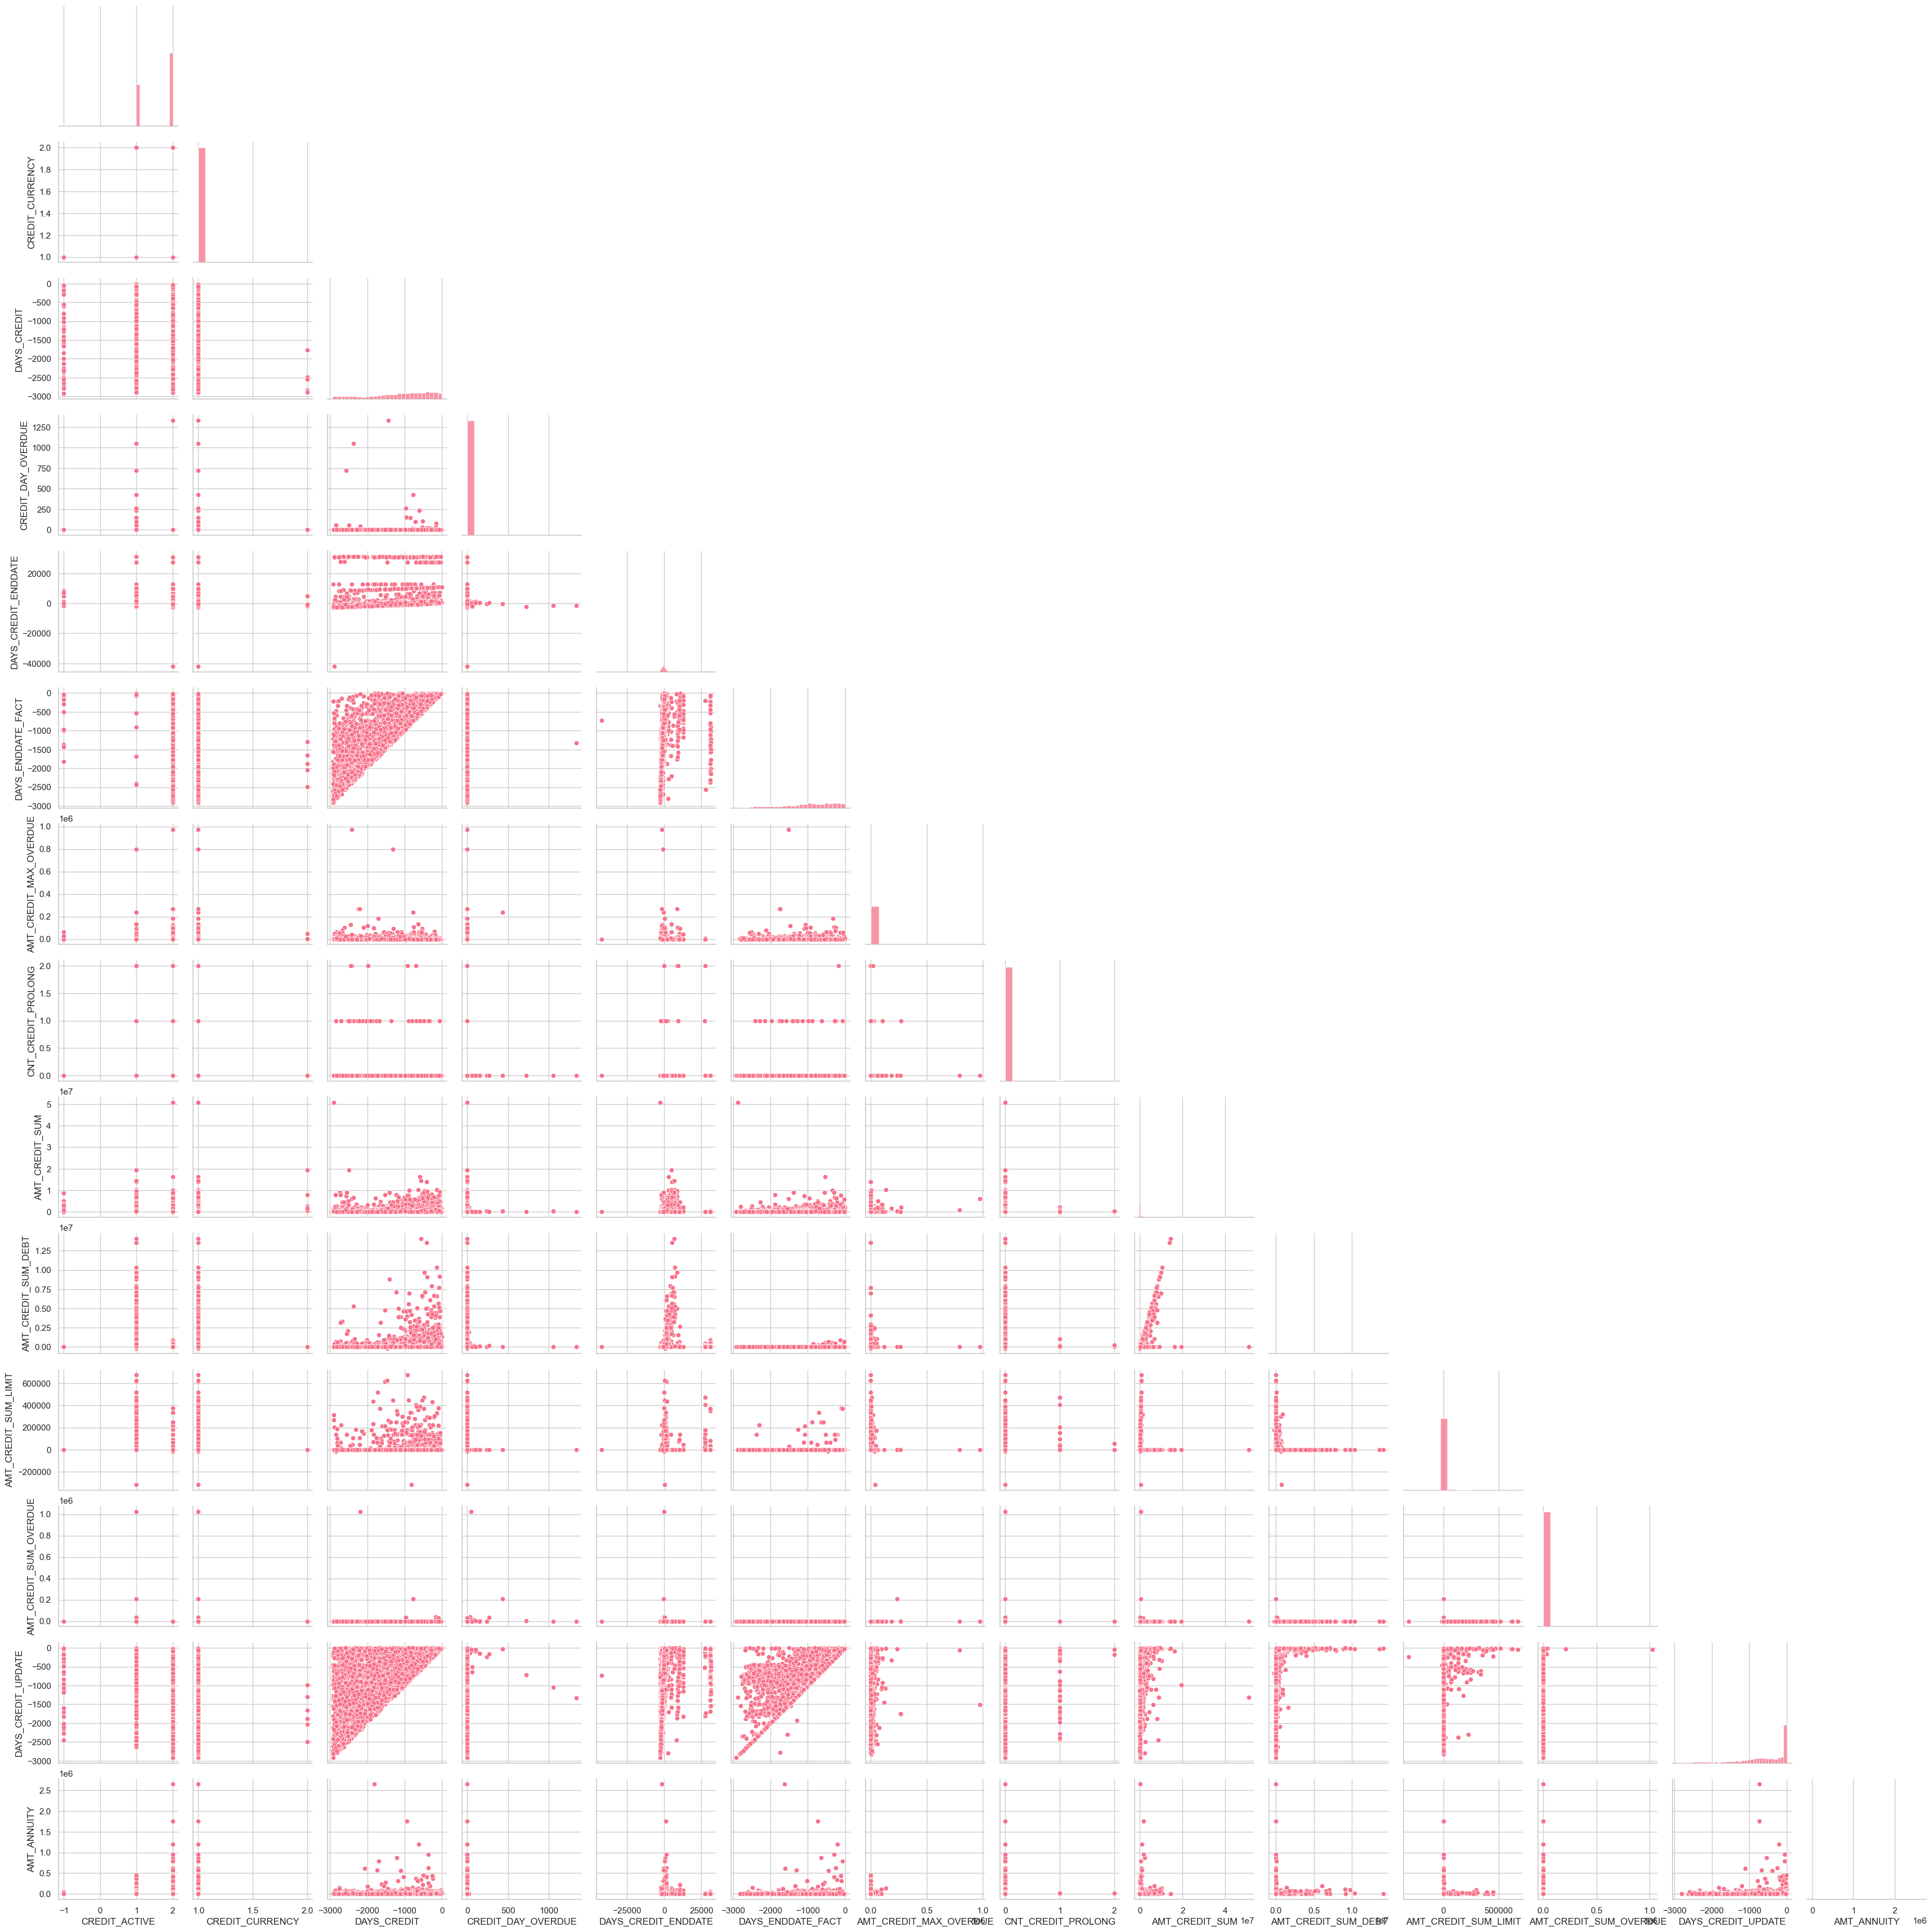

In [14]:
bureau_sample = bureau.sample(n=10000, random_state=42)

sns.pairplot(data=bureau_sample.drop(columns=['SK_ID_CURR', 'SK_ID_BUREAU']), corner=True)
plt.show()

No features look correlated, apart from AMT_CREDIT_SUM_DEBT and AMT_CREDIT_SUM, but even so there's difference of information each of the features bring. Instead, new Ratio features will be created.

## Feature engineering
Creating new features based on ratio and duration of related sets.

In [24]:
bureau[[
    'Application_Duration', 'Update_Duration', 'Remaining_Duration', 
    'RATIO_SUM_DEBT', 'RATION_SUM_LIMIT', 'RATION_SUM_OVERDUE'
        ]] = duckdb.query("""  
    SELECT
    (COALESCE(DAYS_ENDDATE_FACT, 0) - COALESCE(DAYS_CREDIT, 0)) AS Application_Duration,
    (COALESCE(DAYS_CREDIT_UPDATE, 0) - COALESCE(DAYS_CREDIT, 0)) AS Update_Duration,
    (COALESCE(DAYS_CREDIT_ENDDATE, 0) - COALESCE(DAYS_CREDIT, 0)) AS Remaining_Duration,
    (AMT_CREDIT_SUM / AMT_CREDIT_SUM_DEBT) AS RATIO_SUM_DEBT,
    (AMT_CREDIT_SUM / AMT_CREDIT_SUM_LIMIT) AS RATION_SUM_LIMIT,
    (AMT_CREDIT_SUM / AMT_CREDIT_SUM_OVERDUE) AS RATION_SUM_OVERDUE  

    FROM bureau
  """).to_df()

bureau.drop(columns=bureau.filter(like='DAYS', axis=1).columns.to_list(), inplace = True)

In [25]:
bureau_expanded = help_tool.dummy_columns(bureau, ['CREDIT_TYPE', 'CREDIT_ACTIVE'])

Combining bureau_balance and bureau data together.

In [26]:
bureau_combined = duckdb.query("""  
  SELECT A.*, B."MAX(df.STATUS)", B."SUM(df.STATUS)", C.Duration
  FROM bureau_expanded A 
  LEFT JOIN bureau_balance_feature_matrix B
  ON A.SK_ID_BUREAU = B.SK_ID_BUREAU
  LEFT JOIN (
    SELECT SK_ID_BUREAU, MAX(MONTHS_BALANCE) - MIN(MONTHS_BALANCE) AS Duration
    FROM bureau_balance
    GROUP BY SK_ID_BUREAU 
    ) C ON A.SK_ID_BUREAU = C.SK_ID_BUREAU                           
                      
  """).to_df()

### Aggregated features with FeatureTools

In [27]:
bureau_feature_matrix = help_model.aggregated_features(bureau_combined.drop(columns='SK_ID_BUREAU'), 'SK_ID_CURR')
bureau_feature_matrix.shape

(305811, 89)

# Selecting features from combined bureau set

In [28]:
application_train = help_tool.csv_download(r'Archive\home-credit-default-risk\application_train.csv')[['SK_ID_CURR', 'TARGET']]

In [29]:
app_bureau_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET
    FROM bureau_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

app_bureau_feature_matrix['TARGET'].value_counts() / app_bureau_feature_matrix['TARGET'].count() * 100

TARGET
0    92.269945
1     7.730055
Name: count, dtype: float64

#### Biserial correlation
Biserial correlation shows no correlation between created features and TARGET.

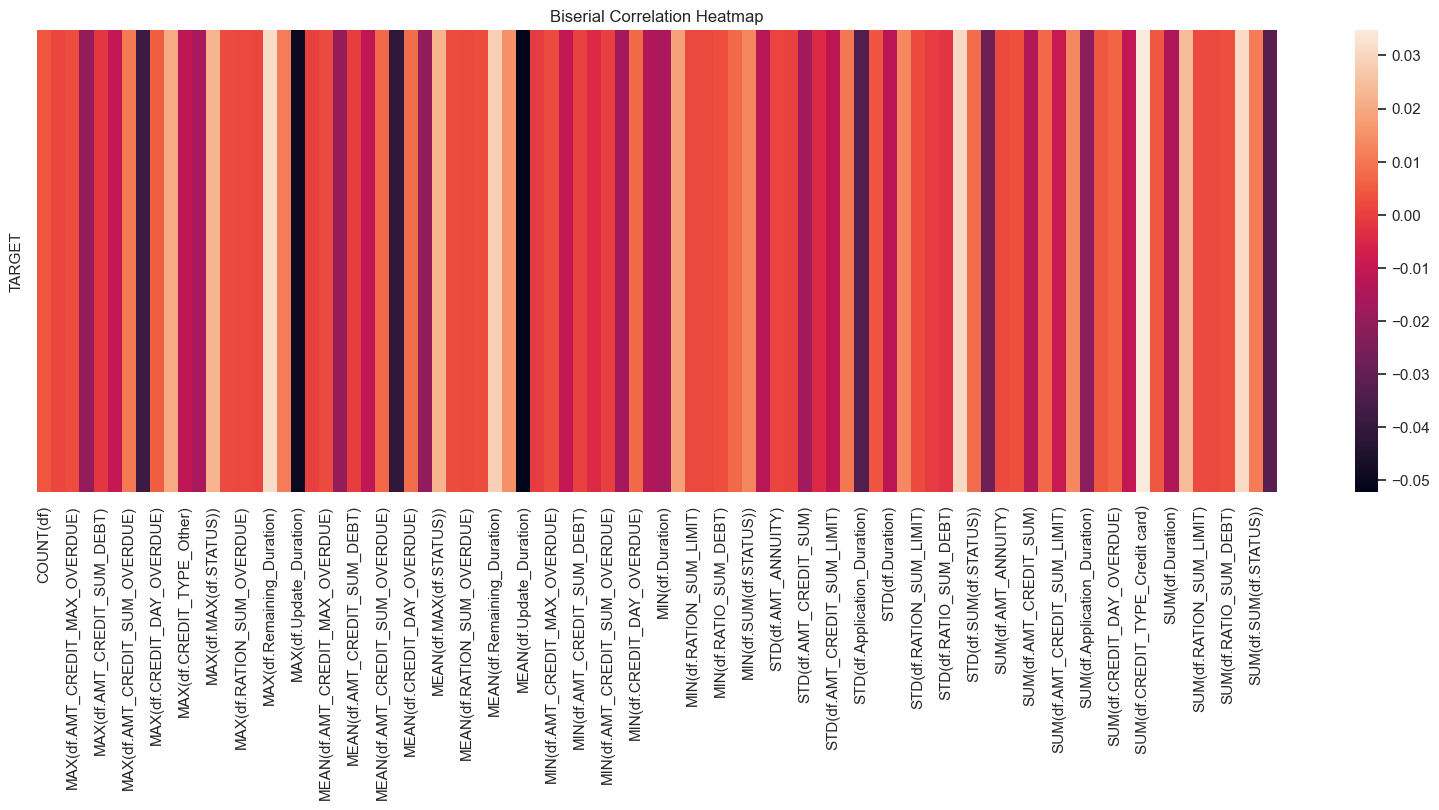

In [115]:
plt.figure(figsize=(20, 6))
help_stats.biserial_heatmap(app_bureau_feature_matrix.fillna(-1), app_bureau_feature_matrix.drop(columns=['SK_ID_CURR', 'TARGET']).columns.to_list(), ['TARGET'])

#### Light XGB

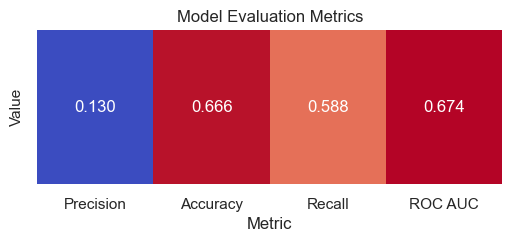

In [30]:
bureau_feature_importance = help_model.model_feature_importance_target(app_bureau_feature_matrix)

#### Top 10 features

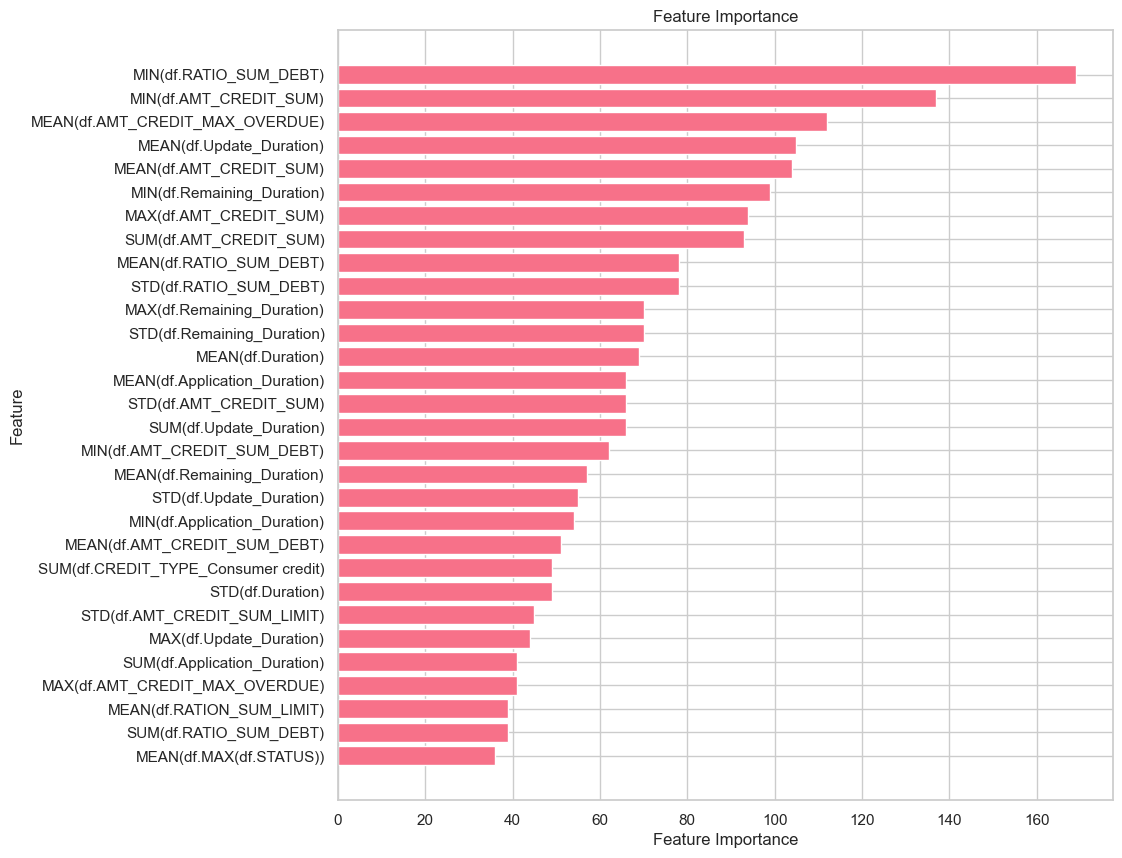

In [31]:
help_model.plot_feature_importance(bureau_feature_importance.head(30))

Top 6 features are not correlated ammong each other.

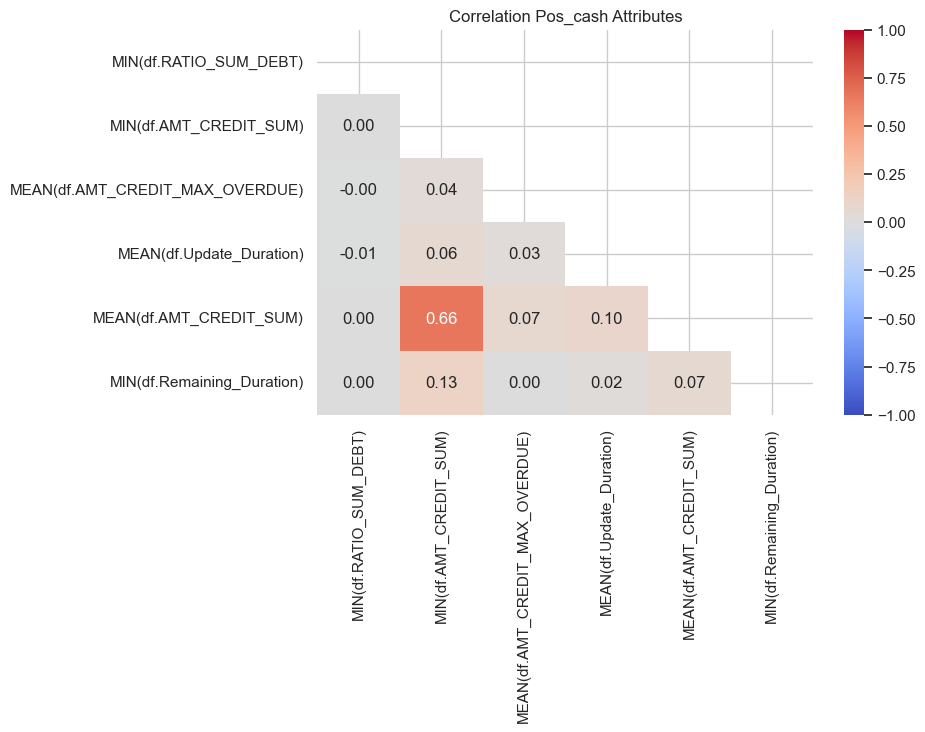

In [44]:
help_visuals.heatmap(app_bureau_feature_matrix[bureau_feature_importance[bureau_feature_importance['importance'] > 95]['feature'].to_list()], 'pos_cash', 'pearson')

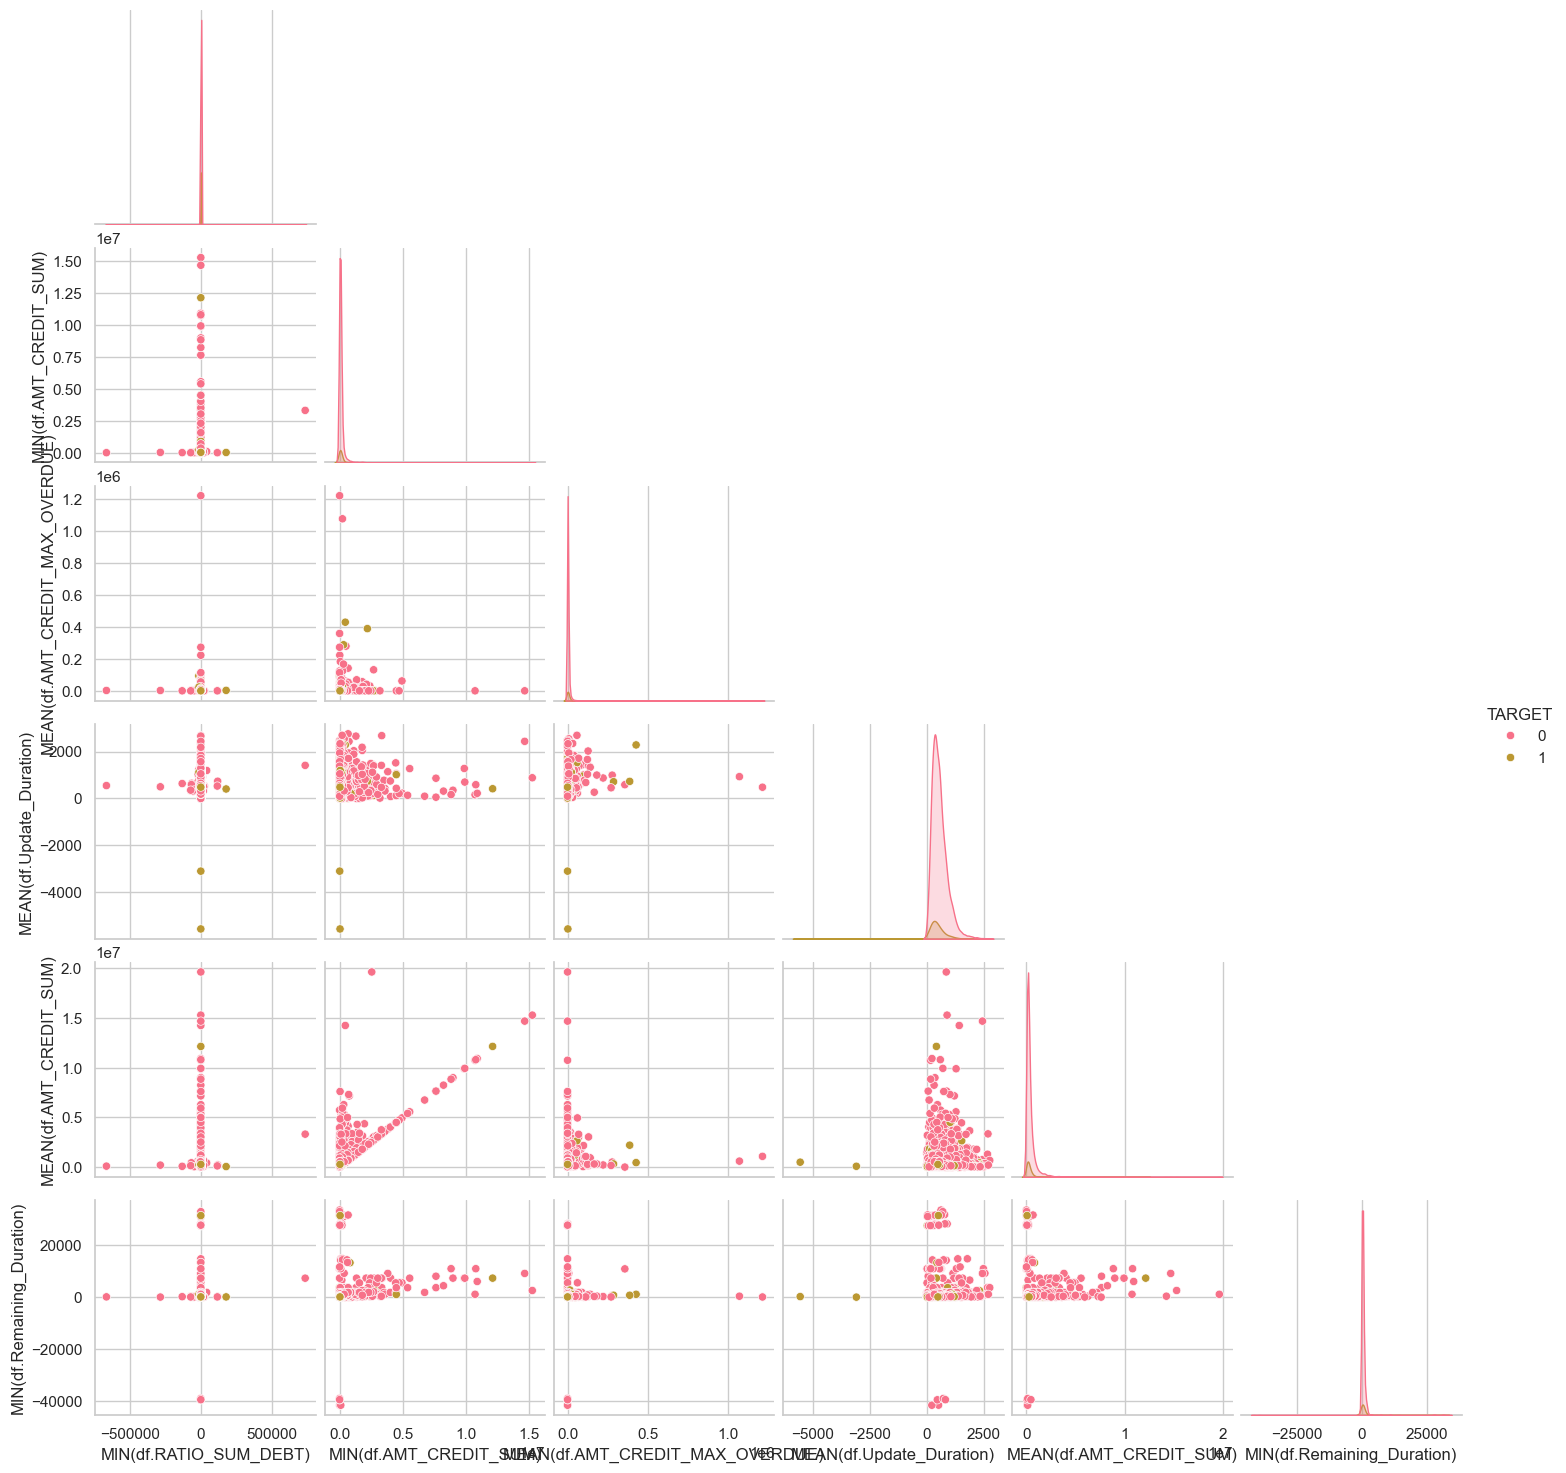

In [45]:
sns.pairplot(app_bureau_feature_matrix[bureau_feature_importance['feature'].head(6).to_list() + ['TARGET']].sample(10000, random_state=42), hue='TARGET', corner=True)
plt.show()

In [48]:
bureau_selected_features = bureau_feature_importance['feature'].head(6).to_list()

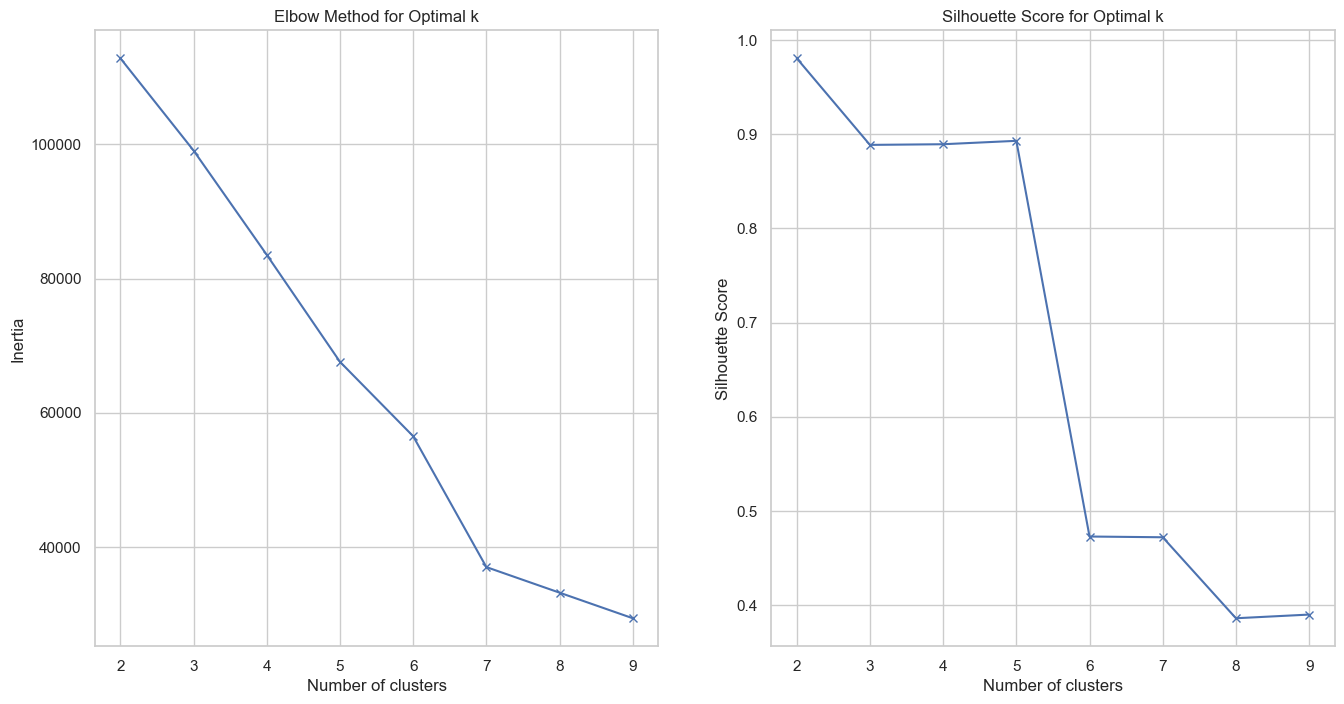

In [49]:
help_model.clustering_k_means_test(bureau_feature_matrix[bureau_selected_features].sample(20000, random_state=42).fillna(0))

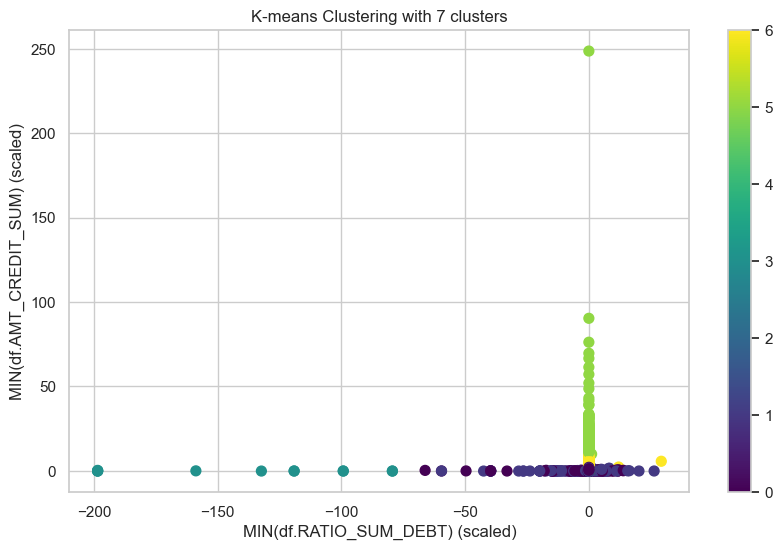

In [51]:
bureau_feature_matrix['Cluster_bureau'] = help_model.clustering_k_means(bureau_feature_matrix[bureau_selected_features].fillna(0), 7)

In [54]:
sorted_bureau_feature_matrix = bureau_feature_matrix[['SK_ID_CURR', 'Cluster_bureau'] + bureau_selected_features]
sorted_bureau_feature_matrix.to_csv(r'Archive\home-credit-default-risk\sorted_bureau_feature_matrix.csv')